#Подключение к google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/skin_cancer"

/content/drive/MyDrive/skin_cancer


#Импорт библиотек

In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

# Загрузка и предобработка данных

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('train/benign',224))
malign_train = np.array(Dataset_loader('train/malignant',224))
benign_test = np.array(Dataset_loader('test/benign',224))
malign_test = np.array(Dataset_loader('test/malignant',224))

100%|██████████| 300/300 [01:24<00:00,  3.57it/s]


# Создание меток класса

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Разделение на тренировочную и тестовую выборку

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Пример изображений с метками

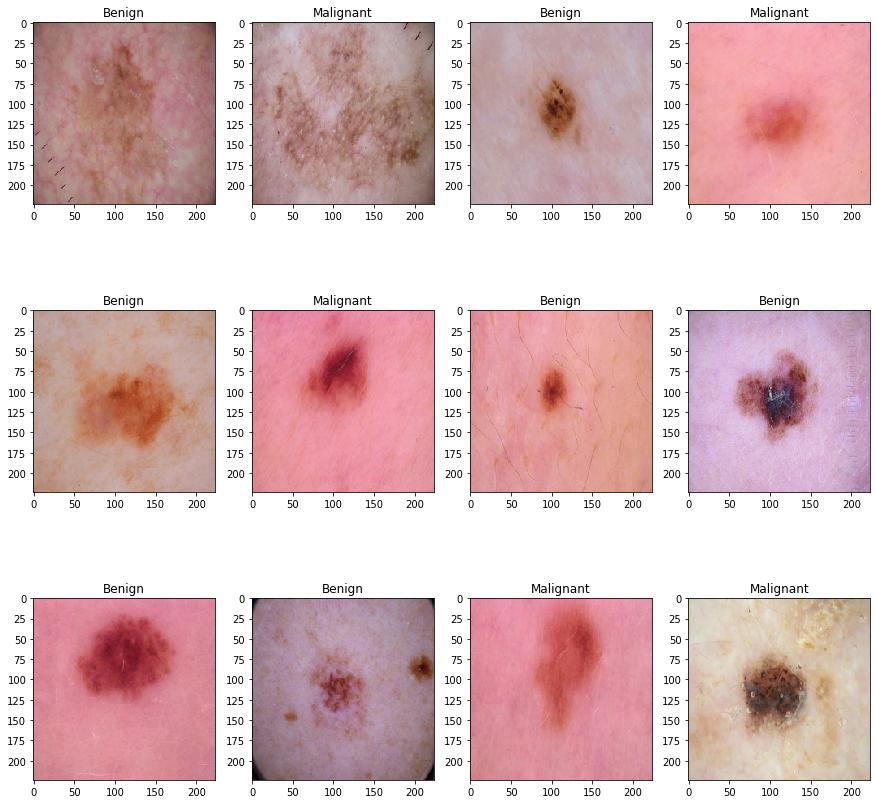

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Генератор тренировочных данных


In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Построение модели: ResNet50

In [ ]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Обучение модели

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
32/32 [==============================] - 1064s 32s/step - loss: 0.4137 - accuracy: 0.8255 - val_loss: 0.5692 - val_accuracy: 0.7386
Epoch 2/10
32/32 [==============================] - 1064s 32s/step - loss: 0.3839 - accuracy: 0.8421 - val_loss: 0.3401 - val_accuracy: 0.8580
Epoch 3/10
32/32 [==============================] - 1063s 32s/step - loss: 0.3361 - accuracy: 0.8464 - val_loss: 0.3044 - val_accuracy: 0.8674
Epoch 4/10
32/32 [==============================] - 1062s 32s/step - loss: 0.3094 - accuracy: 0.8644 - val_loss: 0.2691 - val_accuracy: 0.8807
Epoch 5/10
32/32 [==============================] - 1065s 32s/step - loss: 0.2975 - accuracy: 0.8658 - val_loss: 0.3922 - val_accuracy: 0.8902
Epoch 6/10
32/32 [==============================] - 1062s 32s/step - loss: 0.2972 - accuracy: 0.8687 - val_loss: 0.2301 - val_accuracy: 0.9053
Epoch 7/10
32/32 [==============================] - 1059s 32s/step - loss: 0.2703 - accuracy: 0.8710 - val_loss: 0.2380 - val_accuracy: 0.9053

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

#Сохранение модели

In [ ]:
model.save('skin_cancer_classifier.model')

INFO:tensorflow:Assets written to: skin_cancer_classifier.model/assets


#Графики точности и ошибки

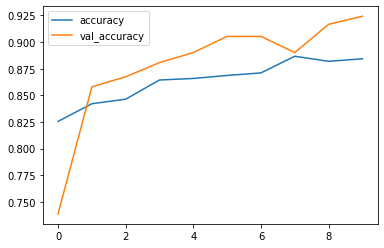

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

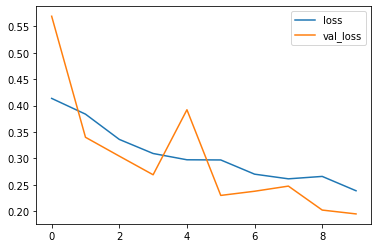

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Предсказание

In [ ]:
loaded_model = tf.keras.models.load_model('skin_cancer_classifier.model')

In [ ]:
Y_val_pred = loaded_model.predict(x_val)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9242424242424242

In [ ]:
Y_pred = loaded_model.predict(X_test)

#Аугментация во время теста (Test-time augmentation, TTA)

In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = loaded_model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [11:19<00:00, 67.90s/it]


### Матрица истинных/ложный предсказаний (Confusion Matrix, CM)

Confusion matrix, without normalization
[[305  55]
 [ 21 279]]


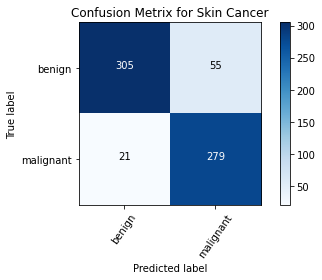

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

###  CM для TTA-предсказаний

Confusion matrix, without normalization
[[319  41]
 [ 31 269]]


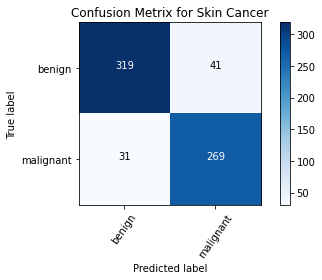

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Отчет классификации

In [ ]:
from sklearn.metrics import classification_report
classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.91      0.89      0.90       360\n           1       0.87      0.90      0.88       300\n\n    accuracy                           0.89       660\n   macro avg       0.89      0.89      0.89       660\nweighted avg       0.89      0.89      0.89       660\n'

### ROC и AUC

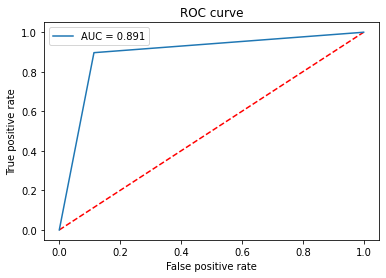

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

###Примеры предсказаний

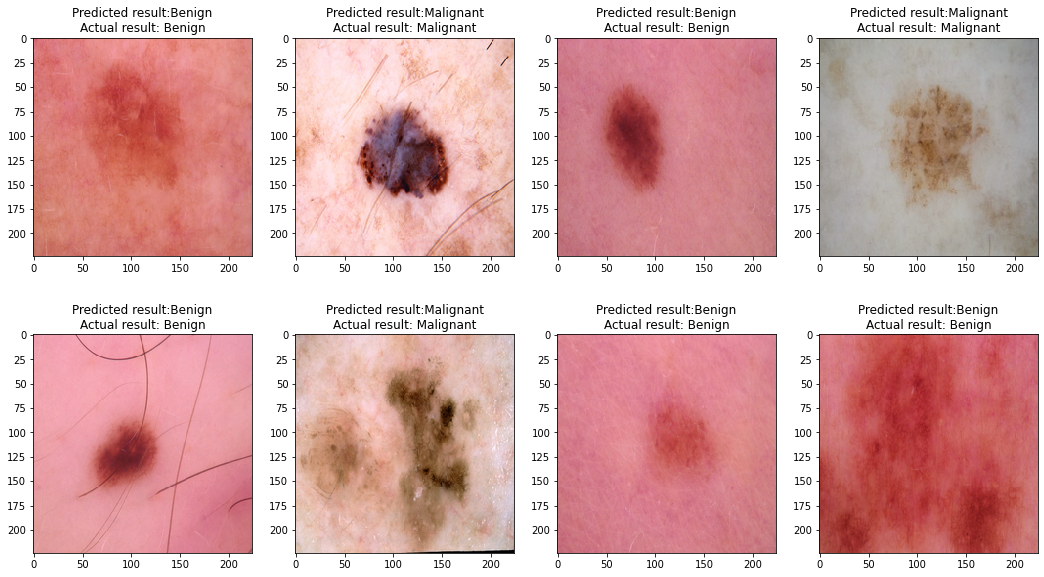

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()